# Python数据分析课设代码第3版

In [17]:
# -*- coding: utf-8 -*-
"""
校园消费行为模拟数据生成器（增强真实版）
增加多种数据问题：缺失值、异常值、特殊值
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

# --------------------------
# 1. 配置参数
# --------------------------
OUTPUT_DIR = "./data/raw"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "student_behavior_raw.xlsx")

# 学生类型分布
STUDENT_DIST = {"学霸型": 0.2, "普通型": 0.6, "风险型": 0.2}
TOTAL_STUDENTS = 500
WEEKS = 16

# 数据问题概率设置
PROBLEM_PROBS = {
    "breakfast_missing": 0.10,  # 早餐缺失率
    "spending_missing": 0.02,   # 消费金额缺失率
    "library_negative": 0.01,   # 图书馆次数负值错误
    "score_extreme": 0.03,      # 成绩极端值
    "dorm_unknown": 0.05        # 宿舍区未知
}

# 基于文献的参数设置
BEHAVIOR_PARAMS = {
    "学霸型": {
        "breakfast_mu": 7.2, "breakfast_sigma": 0.8,
        "library_lambda": 7, "night_alpha": 1.8, "night_beta": 0.6
    },
    "普通型": {
        "breakfast_mu": 8.0, "breakfast_sigma": 1.5,
        "library_lambda": 4, "night_alpha": 3.2, "night_beta": 1.5
    },
    "风险型": {
        "breakfast_mu": 9.8, "breakfast_sigma": 2.2,
        "library_lambda": 1.5, "night_alpha": 4.5, "night_beta": 2.2
    }
}

# --------------------------
# 2. 数据生成函数
# --------------------------
def generate_student_data(student_type, student_id, start_date="2023-09-01"):
    params = BEHAVIOR_PARAMS[student_type]
    records = []
    base_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    for week in range(WEEKS):
        # =====================
        # 1. 基础数据生成
        # =====================
        # 早餐时间（含10%缺失概率）
        has_breakfast = np.random.random() > PROBLEM_PROBS["breakfast_missing"]
        breakfast_value = np.random.normal(
            params["breakfast_mu"], 
            params["breakfast_sigma"]
        )
        breakfast_hour = max(6.0, min(10.0, breakfast_value))
        breakfast_time_str = None
        
        if has_breakfast:
            breakfast_dt = base_date + timedelta(weeks=week, hours=breakfast_hour)
            breakfast_time_str = breakfast_dt.strftime("%H:%M:%S")
        
        # 图书馆次数（泊松分布）
        library_visits = np.random.poisson(params["library_lambda"])
        
        # 夜间消费（伽马分布）
        night_spending = np.random.gamma(params["night_alpha"], params["night_beta"])
        
        # 食堂消费（均匀分布）
        canteen_spending = np.random.uniform(8, 15)
        
        # 学业成绩（基于行为）
        base_score = 82 if student_type == "学霸型" else 68 if student_type == "普通型" else 53
        score_variation = (
            (breakfast_hour - params["breakfast_mu"]) * 3 +
            (library_visits - params["library_lambda"]) * 1.5 +
            np.random.normal(0, 5)
        )
        score = max(30, min(100, base_score + score_variation))
        
        # 宿舍区域
        dorm_area = np.random.choice(["A区", "B区", "C区"], p=[0.3, 0.5, 0.2])
        
        # =====================
        # 2. 注入数据问题
        # =====================
        # 消费金额缺失（2%概率）
        if np.random.random() < PROBLEM_PROBS["spending_missing"]:
            # 随机选择缺失字段
            missing_field = np.random.choice(["night_spend", "canteen_spend"])
            if missing_field == "night_spend":
                night_spending = None
            else:
                canteen_spending = None
        
        # 图书馆次数负值（1%概率）
        if np.random.random() < PROBLEM_PROBS["library_negative"]:
            library_visits = -1  # 系统错误代码
        
        # 成绩极端值（3%概率）
        if np.random.random() < PROBLEM_PROBS["score_extreme"]:
            # 0分（缺考）或超过100分（录入错误）
            score = 0 if np.random.random() < 0.7 else np.random.uniform(101, 120)
        
        # 宿舍区域未知（5%概率）
        if np.random.random() < PROBLEM_PROBS["dorm_unknown"]:
            dorm_area = "-1"  # 表示未知
        
        # =====================
        # 3. 添加异常值
        # =====================
        # 添加5%的极端消费值
        if np.random.random() < 0.05:
            if night_spending is not None:
                night_spending *= np.random.choice([0.1, 5.0])
        
        records.append({
            "stu_id": f"S{student_id:04d}",
            "record_date": (base_date + timedelta(weeks=week)).strftime("%Y-%m-%d"),
            "student_type": student_type,
            "dorm_area": dorm_area,
            "breakfast_time": breakfast_time_str,
            "library_freq": library_visits,
            "night_spend": round(night_spending, 2) if night_spending is not None else None,
            "canteen_spend": round(canteen_spending, 2) if canteen_spending is not None else None,
            "weekly_score": round(score, 1)
        })
    
    return pd.DataFrame(records)

# --------------------------
# 3. 生成完整数据集
# --------------------------
all_students = []
student_count = 1

for st_type, proportion in STUDENT_DIST.items():
    num = int(TOTAL_STUDENTS * proportion)
    for i in range(num):
        df_student = generate_student_data(st_type, student_count)
        all_students.append(df_student)
        student_count += 1

raw_df = pd.concat(all_students, ignore_index=True)

# 添加性别字段（含1%缺失概率）
gender_options = ["男", "女", None]
gender_probs = [0.54, 0.45, 0.01]  # 1%概率缺失
raw_df["gender"] = np.random.choice(gender_options, size=len(raw_df), p=gender_probs)

# --------------------------
# 4. 数据检查与保存
# --------------------------
print("="*50)
print("模拟数据基本信息：")
print("="*50)
print(f"数据集维度：{raw_df.shape}")
print("\n前5条数据示例：")
print(raw_df.head())

print("\n字段统计信息：")
print(raw_df.describe(include='all', datetime_is_numeric=True).fillna('-'))

print("\n缺失值统计：")
print(raw_df.isnull().sum())

print("\n特殊值统计：")
print(f"图书馆负值记录：{(raw_df['library_freq'] < 0).sum()}")
print(f"宿舍未知记录：{(raw_df['dorm_area'] == '-1').sum()}")
print(f"极端成绩记录：{(raw_df['weekly_score'] == 0) | (raw_df['weekly_score'] > 100).sum()}")

# 保存原始数据
raw_df.to_excel(OUTPUT_FILE, index=False, sheet_name='RawData')
print(f"\n模拟数据已保存至：{OUTPUT_FILE}")

模拟数据基本信息：
数据集维度：(8000, 10)

前5条数据示例：
  stu_id record_date student_type dorm_area breakfast_time  library_freq  \
0  S0001  2023-09-01          学霸型        B区       07:27:22             3   
1  S0001  2023-09-08          学霸型        A区       07:23:31             8   
2  S0001  2023-09-15          学霸型        C区       06:59:18             4   
3  S0001  2023-09-22          学霸型        B区       06:05:33             5   
4  S0001  2023-09-29          学霸型        B区       06:40:02             8   

   night_spend  canteen_spend  weekly_score gender  
0         0.61            NaN          80.6      女  
1         1.63          14.55          78.3      女  
2         0.92          11.74          80.7      男  
3         0.70            NaN          69.5      女  
4         0.40           9.06          75.0      女  

字段统计信息：
       stu_id record_date student_type dorm_area breakfast_time library_freq  \
count    8000        8000         8000      8000           7229       8000.0   
unique    500      

In [18]:
# -*- coding: utf-8 -*-
"""
校园消费行为数据预处理管道（最终版）
包含缺失值处理、异常值检测、特征工程等完整流程
"""

import pandas as pd
import numpy as np
# 启用实验性功能以使用IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy import stats
import os

# --------------------------
# 1. 配置参数
# --------------------------
INPUT_FILE = "./data/raw/student_behavior_raw.xlsx"
OUTPUT_DIR = "./data/processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "student_behavior_processed.xlsx")

# 关键字段配置
TIME_COLS = ["breakfast_time"]
NUMERIC_COLS = ["canteen_spend", "library_freq", "night_spend", "weekly_score"]
CATEGORICAL_COLS = ["dorm_area", "gender", "student_type"]

# --------------------------
# 2. 数据加载
# --------------------------
print("="*50)
print("加载原始数据...")
print("="*50)
raw_df = pd.read_excel(
    INPUT_FILE,
    sheet_name='RawData',
    parse_dates=TIME_COLS
)

print("\n原始数据基本信息：")
print(f"数据集维度：{raw_df.shape}")
print("\n前5条数据：")
print(raw_df.head())

print("\n原始数据统计描述：")
# 添加 datetime_is_numeric=True 避免警告
print(raw_df.describe(include='all', datetime_is_numeric=True).fillna('-'))

print("\n原始数据缺失值统计：")
print(raw_df.isnull().sum())

# --------------------------
# 3. 数据预处理函数
# --------------------------
def preprocess_data(df):
    """完整数据预处理流程"""
    df = df.copy()
    
    # 3.1 缺失值处理
    print("\n" + "="*50)
    print("开始缺失值处理...")
    
    # 时间字段：向前填充
    for col in TIME_COLS:
        if col in df.columns:
            # 先填充缺失值再转换类型
            df[col] = df[col].fillna(method='ffill')
            print(f"  - {col}字段：向前填充完成")
    
    # 数值字段：多重插补
    if NUMERIC_COLS:
        # 创建IterativeImputer实例
        imputer = IterativeImputer(max_iter=20, random_state=42)
        df[NUMERIC_COLS] = imputer.fit_transform(df[NUMERIC_COLS])
        print("  - 数值字段：多重插补完成")
    
    # 分类字段：众数填充
    for col in CATEGORICAL_COLS:
        if col in df.columns:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
            print(f"  - {col}字段：众数填充({mode_val})")
    
    # 3.2 异常值处理
    print("\n" + "="*50)
    print("开始异常值检测与处理...")
    
    # IQR方法处理消费金额
    for col in ['night_spend', 'canteen_spend']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = max(0, q1 - 1.5 * iqr)  # 消费金额不能为负
        upper_bound = q3 + 1.5 * iqr
        
        # 缩尾处理（Winsorization）
        df[col] = df[col].clip(lower_bound, upper_bound)
        print(f"  - {col}字段：IQR缩尾处理，边界[{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # Isolation Forest检测多元异常
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(df[NUMERIC_COLS])
    df = df[outliers == 1]  # 保留非异常点
    print(f"  - Isolation Forest检测：移除{sum(outliers == -1)}条异常记录")
    
    # 3.3 特征工程
    print("\n" + "="*50)
    print("开始特征工程...")
    
    # 早餐时间特征 - 确保在缺失值处理后执行
    if 'breakfast_time' in df.columns:
        # 确保时间字段是datetime类型
        if not pd.api.types.is_datetime64_any_dtype(df['breakfast_time']):
            df['breakfast_time'] = pd.to_datetime(df['breakfast_time'])
        
        # 提取小时
        df['breakfast_hour'] = df['breakfast_time'].dt.hour
        
        # 早餐稳定性（3周滑动标准差） - 使用min_periods处理缺失值
        df['breakfast_std_3w'] = df.groupby('stu_id')['breakfast_hour'].transform(
            lambda x: x.rolling(3, min_periods=1).std())
        
        print("  - 新增早餐时间特征")
    
    # 消费模式特征
    if {'canteen_spend', 'night_spend'}.issubset(df.columns):
        # 防止除零错误
        df['night_spend_ratio'] = df['night_spend'] / (df['canteen_spend'] + 1e-6)
        
        # 消费熵值（行为多样性） - 使用apply时处理可能的NaN
        def calc_entropy(row):
            values = [row['canteen_spend'], row['night_spend']]
            if all(pd.notnull(v) for v in values):
                return stats.entropy(values, base=2)
            return np.nan
        
        df['spend_entropy'] = df.apply(calc_entropy, axis=1)
        print("  - 新增消费模式特征")
    
    # 学业行为关联特征
    df['study_consume_corr'] = df['library_freq'] / (df['night_spend'] + 0.5)
    print("  - 新增学业-消费关联特征")
    
    # 最终检查：确保没有缺失值
    df = df.dropna()
    print(f"  - 最终数据清洗：移除{len(df) - len(df.dropna())}条含缺失值的记录")
    
    return df

# --------------------------
# 4. 执行预处理
# --------------------------
processed_df = preprocess_data(raw_df)

# --------------------------
# 5. 结果检查与保存
# --------------------------
print("\n" + "="*50)
print("预处理后数据检查：")
print("="*50)
print(f"处理后数据集维度：{processed_df.shape}")
print("\n处理后前5条数据：")
print(processed_df.head())

print("\n处理后统计描述：")
# 添加 datetime_is_numeric=True 避免警告
print(processed_df.describe(include='all', datetime_is_numeric=True).fillna('-'))

print("\n处理后缺失值统计：")
print(processed_df.isnull().sum())

# 保存处理结果
processed_df.to_excel(OUTPUT_FILE, index=False, sheet_name='ProcessedData')
print(f"\n处理后的数据已保存至：{OUTPUT_FILE}")

加载原始数据...

原始数据基本信息：
数据集维度：(8000, 10)

前5条数据：
  stu_id record_date student_type dorm_area      breakfast_time  library_freq  \
0  S0001  2023-09-01          学霸型        B区 2025-06-08 07:27:22             3   
1  S0001  2023-09-08          学霸型        A区 2025-06-08 07:23:31             8   
2  S0001  2023-09-15          学霸型        C区 2025-06-08 06:59:18             4   
3  S0001  2023-09-22          学霸型        B区 2025-06-08 06:05:33             5   
4  S0001  2023-09-29          学霸型        B区 2025-06-08 06:40:02             8   

   night_spend  canteen_spend  weekly_score gender  
0         0.61            NaN          80.6      女  
1         1.63          14.55          78.3      女  
2         0.92          11.74          80.7      男  
3         0.70            NaN          69.5      女  
4         0.40           9.06          75.0      女  

原始数据统计描述：
       stu_id record_date student_type dorm_area  \
count    8000        8000         8000      8000   
unique    500          16         


处理后的数据已保存至：./data/processed\student_behavior_processed.xlsx


In [19]:
#数据分析及可视化

In [20]:
import os
print(os.getcwd())  # 显示当前工作目录--resovling data path problem.....hhh

C:\Users\86178\PythonHomework\221549210钟京赛实验1


数据概览：
数据集维度：(7100, 15)

前5条数据：


,stu_id,record_date,student_type,dorm_area,breakfast_time,library_freq,night_spend,canteen_spend,weekly_score,gender,breakfast_hour,breakfast_std_3w,night_spend_ratio,spend_entropy,study_consume_corr
0,S0001,2023-09-08,学霸型,A区,2025-06-08 07:23:31,8,1.63,14.550000,78.3,女,7,0.000000,0.112027,0.471342,3.755869
1,S0001,2023-09-15,学霸型,C区,2025-06-08 06:59:18,4,0.92,11.740000,80.7,男,6,0.577350,0.078365,0.375809,2.816901
2,S0001,2023-09-22,学霸型,B区,2025-06-08 06:05:33,5,0.70,11.497854,69.5,女,6,0.577350,0.060881,0.316984,4.166667
3,S0001,2023-09-29,学霸型,B区,2025-06-08 06:40:02,8,0.40,9.060000,75.0,女,6,0.000000,0.044150,0.252665,8.888889
4,S0001,2023-10-06,学霸型,C区,2025-06-08 08:14:54,-1,1.82,14.800000,75.1,女,8,1.154701,0.122973,0.498426,-0.431034



数据类型和缺失值检查：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   stu_id              7100 non-null   object        
 1   record_date         7100 non-null   object        
 2   student_type        7100 non-null   object        
 3   dorm_area           7100 non-null   object        
 4   breakfast_time      7100 non-null   datetime64[ns]
 5   library_freq        7100 non-null   int64         
 6   night_spend         7100 non-null   float64       
 7   canteen_spend       7100 non-null   float64       
 8   weekly_score        7100 non-null   float64       
 9   gender              7100 non-null   object        
 10  breakfast_hour      7100 non-null   int64         
 11  breakfast_std_3w    7100 non-null   float64       
 12  night_spend_ratio   7100 non-null   float64       
 13  spend_entropy       7100 non-null  

None


描述性统计分析

数值变量描述统计：


,count,mean,std,min,25%,50%,75%,max
canteen_spend,7100.0,11.488244,1.992765,8.000000,9.770000,11.496970,13.200000,15.000000
library_freq,7100.0,4.026901,2.568456,-1.000000,2.000000,4.000000,6.000000,14.000000
night_spend,7100.0,4.897904,3.763457,0.020000,1.900000,4.130000,6.952500,14.981250
weekly_score,7100.0,67.527803,12.124577,0.000000,59.700000,68.000000,75.600000,119.800000
breakfast_hour,7100.0,7.682394,1.372090,6.000000,7.000000,7.000000,9.000000,10.000000
breakfast_std_3w,7100.0,0.973432,0.627011,0.000000,0.577350,1.000000,1.527525,2.828427
night_spend_ratio,7100.0,0.439962,0.350763,0.001709,0.164518,0.362732,0.627292,1.851823
spend_entropy,7100.0,0.743609,0.256435,0.018151,0.587570,0.835929,0.959791,1.000000
study_consume_corr,7100.0,1.746912,2.522976,-1.369863,0.311850,0.790514,1.928906,21.818182



分类变量统计：

student_type分布：


普通型    0.611549
学霸型    0.195493
风险型    0.192958
Name: student_type, dtype: float64


dorm_area分布：


B区    0.465211
A区    0.290563
C区    0.193521
-1    0.050704
Name: dorm_area, dtype: float64


gender分布：


男    0.55831
女    0.44169
Name: gender, dtype: float64


数据可视化分析


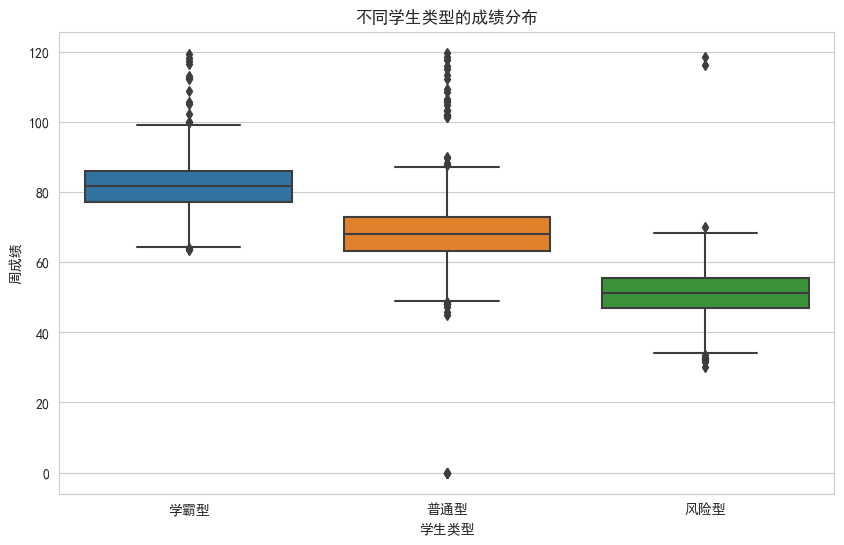

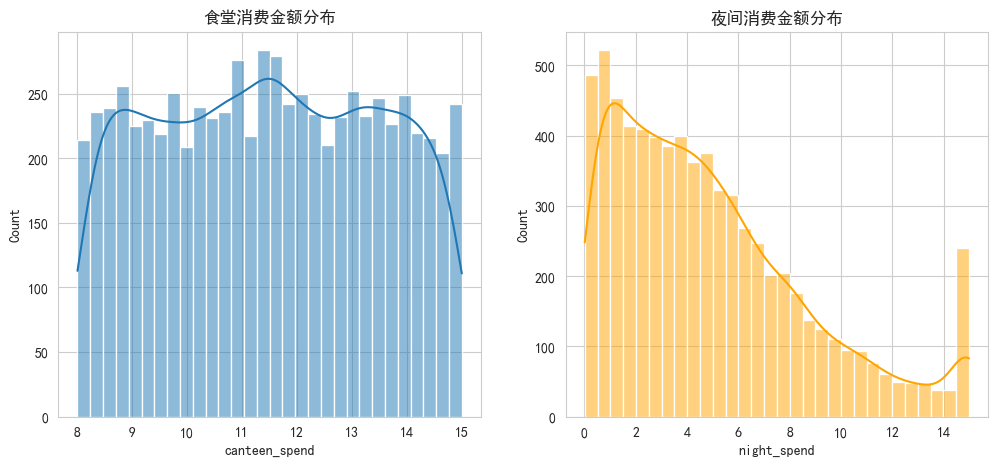

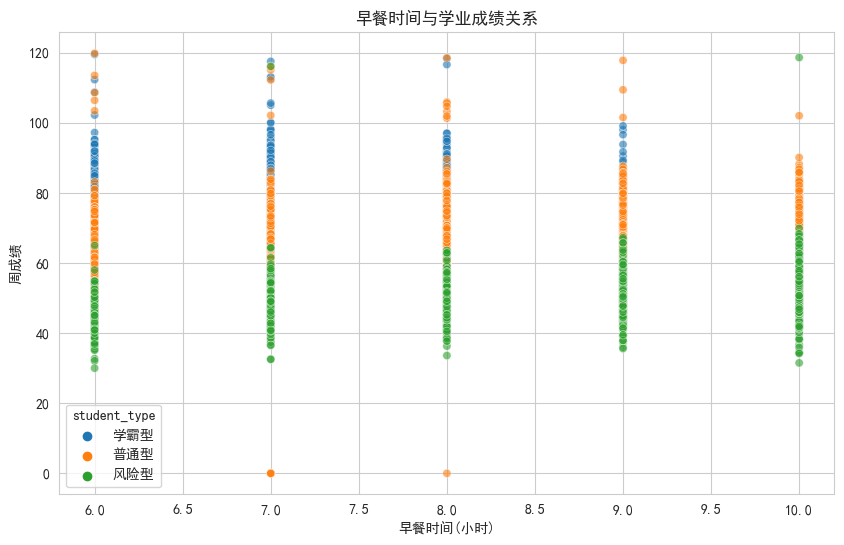

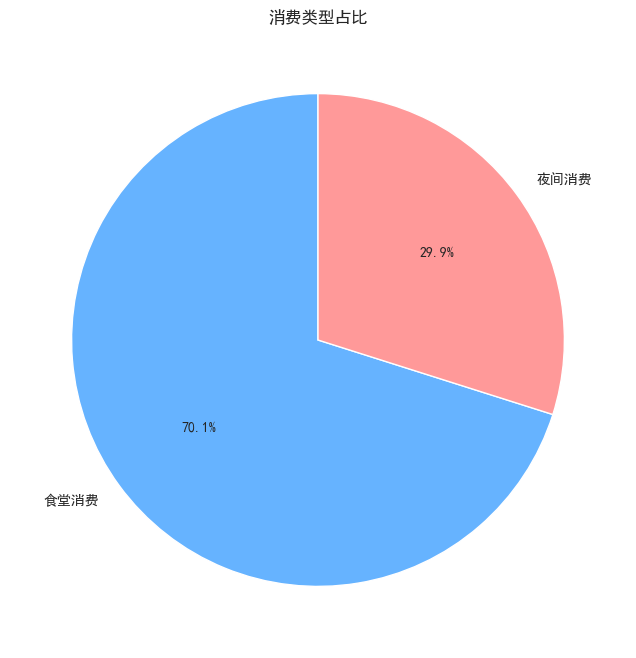

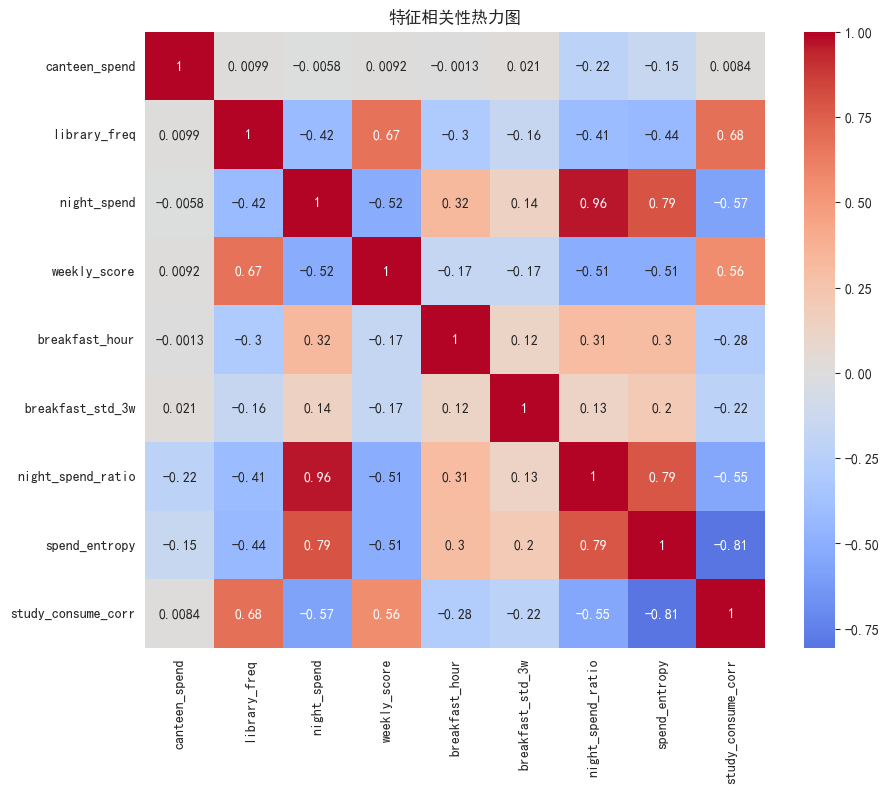


学业预警与行为推荐

学业预警(成绩后15%)：共199名学生
示例预警消息：
同学 S0469：您近期的学业成绩不太理想，要努力加油呀！
同学 S0148：您近期的学业成绩不太理想，要努力加油呀！
同学 S0461：您近期的学业成绩不太理想，要努力加油呀！

学习强度提示(图书馆前10%)：共264名学生
示例提示消息：
同学 S0199：学习之余也要注意休息哦！
同学 S0386：学习之余也要注意休息哦！
同学 S0357：学习之余也要注意休息哦！

消费提示(食堂消费前5%)：共258名学生
示例提示消息：
同学 S0005：美食虽能让人忘却烦恼，也要注意不要暴饮暴食哦！
同学 S0129：美食虽能让人忘却烦恼，也要注意不要暴饮暴食哦！
同学 S0106：美食虽能让人忘却烦恼，也要注意不要暴饮暴食哦！

学生成绩趋势分析


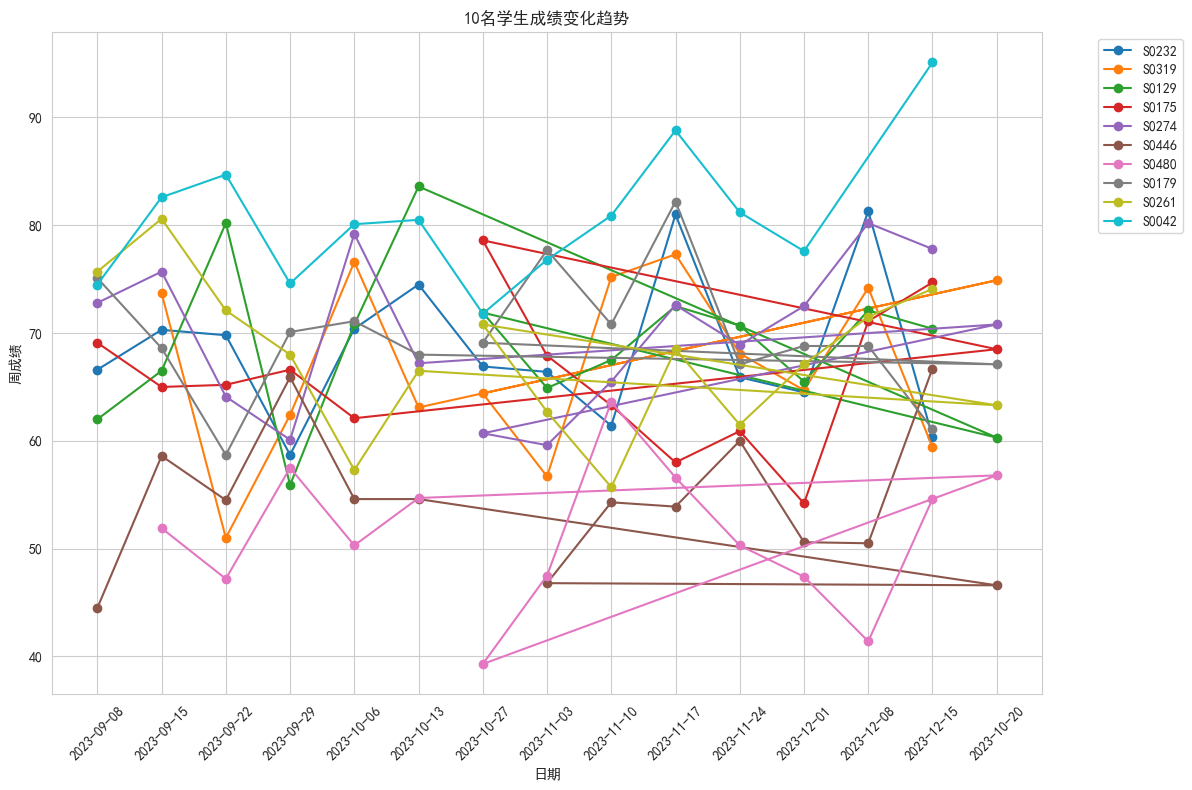


学生行为聚类分析


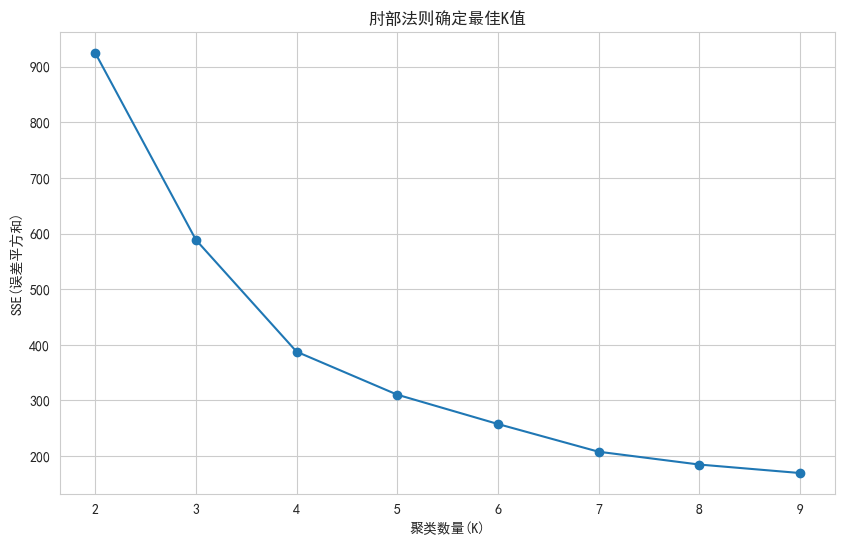


聚类轮廓系数：0.435


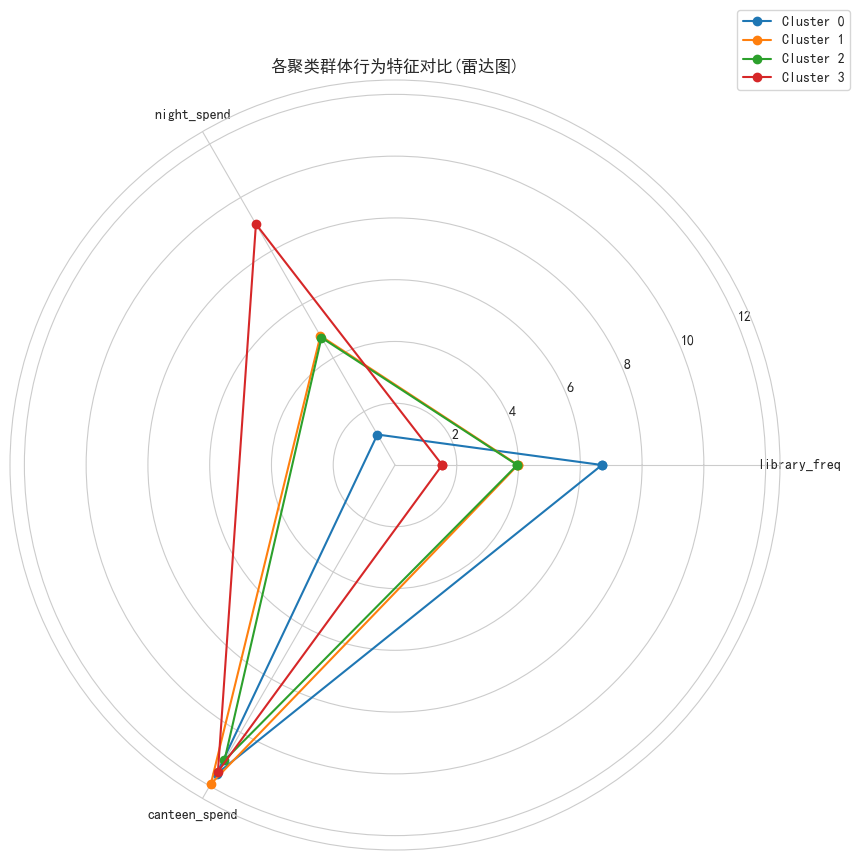


各聚类群体特征描述：


,library_freq,night_spend,canteen_spend
cluster,,,
0,6.699945,1.138901,11.547533
1,3.980315,4.831285,11.926297
2,3.955153,4.761639,11.044032
3,1.528415,9.006022,11.466115


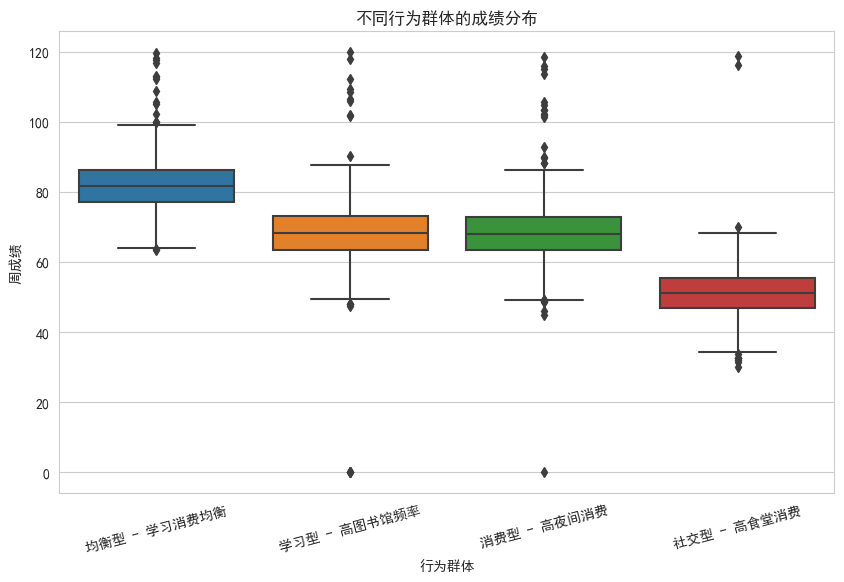


学生成长轨迹分析


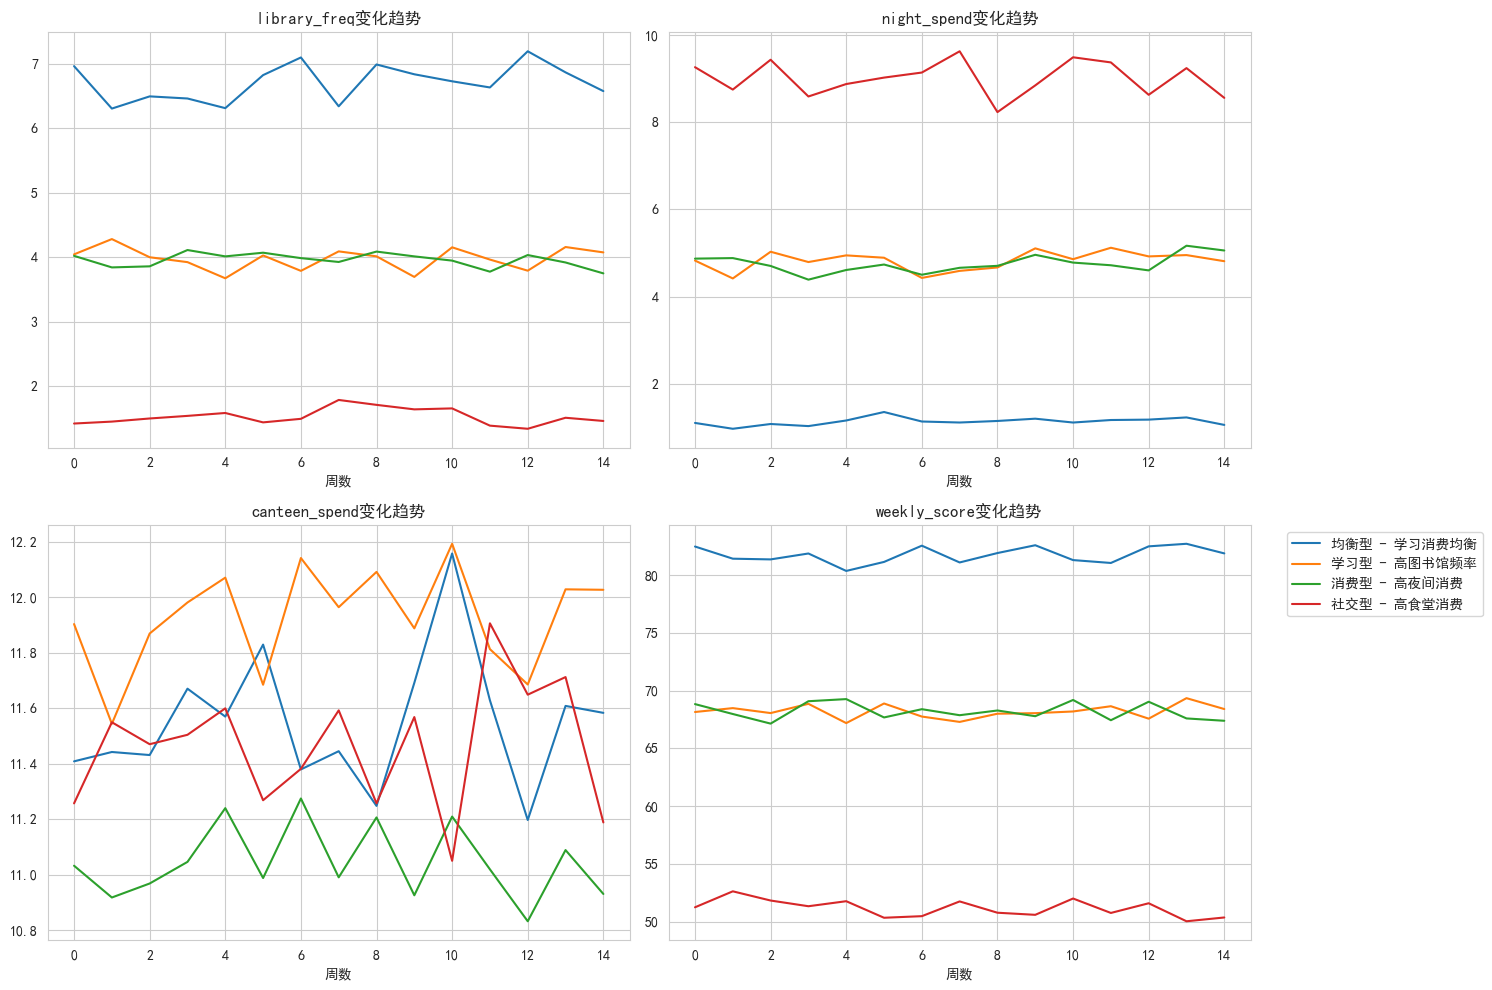


分析完成！带有聚类标签的数据已保存。
📊 SVD学习资源推荐（新记录解决推荐人出现重复数据问题）

🔍 学霸型学生推荐示例（随机5名）:


,stu_id,weekly_score,recommended_resource
1192,S0086,85.9,学习小组
124,S0009,81.2,学习小组
358,S0026,79.6,学习小组
180,S0013,80.5,学习小组
487,S0035,87.7,学习小组



🔍 普通型学生推荐示例（随机5名）:


,stu_id,weekly_score,recommended_resource
2978,S0210,77.2,学习小组
3718,S0261,74.1,在线测验
2673,S0189,64.5,视频课程
4942,S0346,60.6,在线测验
3412,S0240,70.3,在线测验



🔍 风险型学生推荐示例（随机5名）:


,stu_id,weekly_score,recommended_resource
6972,S0491,36.3,视频课程
6039,S0423,57.3,视频课程
6915,S0487,45.4,视频课程
6381,S0448,54.0,视频课程
6720,S0473,47.6,视频课程


图片已保存至: ./data/visualization/SVD_Recommend.png


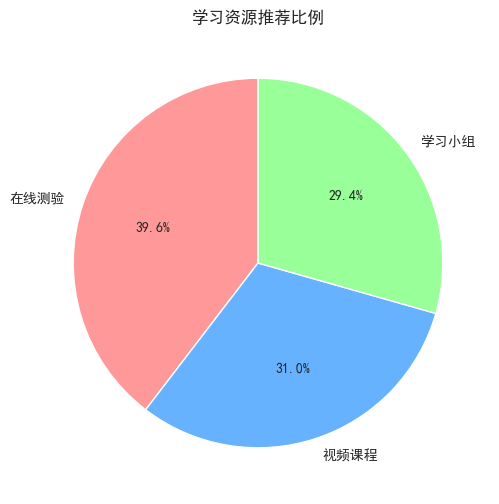

KNN同伴推荐结果展示

学霸型学生推荐示例（随机3名）:

学生ID: S0064
周成绩: 79.0
推荐同伴:
 - S0055 (学霸型, 成绩: 78.1)
 - S0095 (学霸型, 成绩: 88.0)
 - S0036 (学霸型, 成绩: 65.4)
 - S0027 (学霸型, 成绩: 89.8)

学生ID: S0035
周成绩: 87.7
推荐同伴:
 - S0003 (学霸型, 成绩: 74.4)
 - S0058 (学霸型, 成绩: 77.4)
 - S0036 (学霸型, 成绩: 65.4)
 - S0015 (学霸型, 成绩: 76.9)

学生ID: S0011
周成绩: 78.1
推荐同伴:
 - S0022 (学霸型, 成绩: 79.2)
 - S0080 (学霸型, 成绩: 77.3)
 - S0076 (学霸型, 成绩: 82.4)
 - S0058 (学霸型, 成绩: 77.4)

普通型学生推荐示例（随机3名）:

学生ID: S0219
周成绩: 70.8
推荐同伴:
 - S0358 (普通型, 成绩: 72.4)
 - S0301 (普通型, 成绩: 73.9)
 - S0254 (普通型, 成绩: 73.1)
 - S0164 (普通型, 成绩: 68.0)

学生ID: S0355
周成绩: 73.2
推荐同伴:
 - S0393 (普通型, 成绩: 67.7)
 - S0389 (普通型, 成绩: 58.8)
 - S0206 (普通型, 成绩: 56.9)
 - S0344 (普通型, 成绩: 77.2)

学生ID: S0297
周成绩: 61.3
推荐同伴:
 - S0181 (普通型, 成绩: 74.6)
 - S0295 (普通型, 成绩: 62.9)
 - S0281 (普通型, 成绩: 70.4)
 - S0131 (普通型, 成绩: 64.3)

风险型学生推荐示例（随机3名）:

学生ID: S0466
周成绩: 52.9
推荐同伴:
 - S0499 (风险型, 成绩: 50.0)
 - S0423 (风险型, 成绩: 57.3)
 - S0440 (风险型, 成绩: 48.4)
 - S0448 (风险型, 成绩: 54.0)

学生ID: S0487
周成绩: 45.4
推荐同伴:
 -

In [21]:
# -*- coding: utf-8 -*-
"""
校园消费行为数据分析与可视化
包含：描述性统计、学业预警、行为聚类、成长轨迹分析等
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimSun-']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
sns.set_style('whitegrid')

# --------------------------
# 1. 数据加载与预处理检查
# --------------------------
# 从预处理后的文件加载数据
df = pd.read_excel('./data/processed/student_behavior_processed.xlsx', 
                   sheet_name='ProcessedData')

print("数据概览：")
print(f"数据集维度：{df.shape}")
print("\n前5条数据：")
display(df.head())

# 检查数据类型和缺失值
print("\n数据类型和缺失值检查：")
display(df.info())

# --------------------------
# 2. 描述性统计分析
# --------------------------
print("\n" + "="*50)
print("描述性统计分析")
print("="*50)

# 2.1 数值型变量统计
num_cols = ['canteen_spend', 'library_freq', 'night_spend', 'weekly_score', 
            'breakfast_hour', 'breakfast_std_3w', 'night_spend_ratio', 
            'spend_entropy', 'study_consume_corr']

print("\n数值变量描述统计：")
display(df[num_cols].describe().T)

# 2.2 分类变量统计
cat_cols = ['student_type', 'dorm_area', 'gender']
print("\n分类变量统计：")
for col in cat_cols:
    print(f"\n{col}分布：")
    display(df[col].value_counts(normalize=True))

# --------------------------
# 3. 数据可视化分析
# --------------------------
print("\n" + "="*50)
print("数据可视化分析")
print("="*50)
# 设置中文字体为SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 3.1 学生类型与成绩关系 - 箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='student_type', y='weekly_score', data=df, order=['学霸型', '普通型', '风险型'])
plt.title('不同学生类型的成绩分布')
plt.xlabel('学生类型')
plt.ylabel('周成绩')
plt.savefig('./data/visualization/student_type_score.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 消费金额分布 - 直方图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['canteen_spend'], bins=30, kde=True)
plt.title('食堂消费金额分布')

plt.subplot(1, 2, 2)
sns.histplot(df['night_spend'], bins=30, kde=True, color='orange')
plt.title('夜间消费金额分布')
plt.savefig('./data/visualization/spending_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.3 早餐时间与成绩关系 - 散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='breakfast_hour', y='weekly_score', hue='student_type', data=df, alpha=0.6)
plt.title('早餐时间与学业成绩关系')
plt.xlabel('早餐时间(小时)')
plt.ylabel('周成绩')
plt.savefig('./data/visualization/breakfast_score.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.4 消费模式占比 - 饼图
plt.figure(figsize=(8, 8))
spend_ratio = df[['canteen_spend', 'night_spend']].mean()
plt.pie(spend_ratio, labels=['食堂消费', '夜间消费'], autopct='%1.1f%%', 
        colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('消费类型占比')
plt.savefig('./data/visualization/spending_pie.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.5 特征相关性 - 热力图
plt.figure(figsize=(10, 8))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('特征相关性热力图')
plt.savefig('./data/visualization/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------
# 4. 学业预警与行为推荐
# --------------------------
print("\n" + "="*50)
print("学业预警与行为推荐")
print("="*50)

# 4.1 学业预警 - 成绩后15%的学生
score_threshold = df['weekly_score'].quantile(0.15)
low_score_students = df[df['weekly_score'] <= score_threshold]['stu_id'].unique()

print(f"\n学业预警(成绩后15%)：共{len(low_score_students)}名学生")
print("示例预警消息：")
for stu_id in np.random.choice(low_score_students, size=3, replace=False):
    print(f"同学 {stu_id}：您近期的学业成绩不太理想，要努力加油呀！")

# 4.2 学习强度提示 - 图书馆次数前10%的学生
library_threshold = df['library_freq'].quantile(0.9)
high_library_students = df[df['library_freq'] >= library_threshold]['stu_id'].unique()

print(f"\n学习强度提示(图书馆前10%)：共{len(high_library_students)}名学生")
print("示例提示消息：")
for stu_id in np.random.choice(high_library_students, size=3, replace=False):
    print(f"同学 {stu_id}：学习之余也要注意休息哦！")

# 4.3 消费提示 - 食堂消费前5%的学生
canteen_threshold = df['canteen_spend'].quantile(0.95)
high_canteen_students = df[df['canteen_spend'] >= canteen_threshold]['stu_id'].unique()

print(f"\n消费提示(食堂消费前5%)：共{len(high_canteen_students)}名学生")
print("示例提示消息：")
for stu_id in np.random.choice(high_canteen_students, size=3, replace=False):
    print(f"同学 {stu_id}：美食虽能让人忘却烦恼，也要注意不要暴饮暴食哦！")

# --------------------------
# 5. 学生成绩趋势分析
# --------------------------
print("\n" + "="*50)
print("学生成绩趋势分析")
print("="*50)

# 设置中文字体为SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 随机选择10名学生
sample_students = np.random.choice(df['stu_id'].unique(), size=10, replace=False)
sample_data = df[df['stu_id'].isin(sample_students)]


# 绘制成绩变化趋势
plt.figure(figsize=(12, 8))
for stu_id in sample_students:
    stu_data = sample_data[sample_data['stu_id'] == stu_id]
    plt.plot(stu_data['record_date'], stu_data['weekly_score'], 
             label=stu_id, marker='o')

plt.title('10名学生成绩变化趋势')
plt.xlabel('日期')
plt.ylabel('周成绩')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./data/visualization/score_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------
# 6. 学生行为聚类分析
# --------------------------
print("\n" + "="*50)
print("学生行为聚类分析")
print("="*50)

# 6.1 准备聚类特征
cluster_features = ['library_freq', 'night_spend', 'canteen_spend']
cluster_data = df.groupby('stu_id')[cluster_features].mean()

# 标准化数据
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# 6.2 使用肘部法则确定最佳K值
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('聚类数量(K)')
plt.ylabel('SSE(误差平方和)')
plt.title('肘部法则确定最佳K值')
plt.savefig('./data/visualization/elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.3 根据肘部法则选择K=4进行聚类
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# 计算轮廓系数
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(f"\n聚类轮廓系数：{silhouette_avg:.3f}")

# 添加聚类标签到数据
cluster_data['cluster'] = cluster_labels

# 6.4 聚类结果可视化
# 设置中文字体为SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False
# 各聚类中心特征对比 - 雷达图
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
angles = np.linspace(0, 2*np.pi, len(cluster_features), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # 闭合

plt.figure(figsize=(10, 10))
for i in range(best_k):
    values = np.concatenate((cluster_centers[i], [cluster_centers[i][0]]))
    plt.polar(angles, values, marker='o', label=f'Cluster {i}')

plt.xticks(angles[:-1], cluster_features)
plt.title('各聚类群体行为特征对比(雷达图)')
plt.legend(bbox_to_anchor=(1.1, 1.1))
plt.savefig('./data/visualization/cluster_radar.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.5 聚类群体描述
cluster_desc = cluster_data.groupby('cluster').mean()
print("\n各聚类群体特征描述：")
display(cluster_desc)

# 为每个聚类命名
cluster_names = {
    0: "均衡型 - 学习消费均衡",
    1: "学习型 - 高图书馆频率",
    2: "消费型 - 高夜间消费",
    3: "社交型 - 高食堂消费"
}

# 添加聚类名称到原始数据
cluster_data['cluster_name'] = cluster_data['cluster'].map(cluster_names)
df = df.merge(cluster_data[['cluster_name']], left_on='stu_id', right_index=True)

# 6.6 聚类群体成绩对比
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_name', y='weekly_score', data=df, 
            order=cluster_names.values())
plt.title('不同行为群体的成绩分布')
plt.xlabel('行为群体')
plt.ylabel('周成绩')
plt.xticks(rotation=15)
plt.savefig('./data/visualization/cluster_score.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------
# 7. 学生成长轨迹分析
# --------------------------
print("\n" + "="*50)
print("学生成长轨迹分析")
print("="*50)

# 设置中文字体为SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 按时间分析行为变化
df['record_date'] = pd.to_datetime(df['record_date'])
df['week_num'] = (df['record_date'] - df['record_date'].min()).dt.days // 7

# 按周分析各群体的平均行为变化
weekly_trend = df.groupby(['week_num', 'cluster_name'])[cluster_features + ['weekly_score']].mean().reset_index()

# 绘制成长轨迹
plt.figure(figsize=(15, 10))
for i, feature in enumerate(cluster_features + ['weekly_score'], 1):
    plt.subplot(2, 2, i)
    for cluster in cluster_names.values():
        cluster_data = weekly_trend[weekly_trend['cluster_name'] == cluster]
        plt.plot(cluster_data['week_num'], cluster_data[feature], label=cluster)
    plt.title(f'{feature}变化趋势')
    plt.xlabel('周数')
    if i == len(cluster_features) + 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./data/visualization/growth_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# 保存带有聚类标签的数据
df.to_excel('./data/processed/student_behavior_with_cluster.xlsx', index=False)
print("\n分析完成！带有聚类标签的数据已保存。")


##SVD、KNN模型进行学习方式推荐和学习同伴推荐
# --------------------------
#8、SVD学习资源推荐
# 设置中文字体为SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False
def show_svd_recommendations(df, num_samples=5, save_path='./data/visualization/SVD_Recommend.png'):
    """
    展示SVD推荐结果并可选择保存图片
    
    参数:
    df: 包含推荐结果的数据框
    num_samples: 每种类型展示的样本数量
    save_path: 图片保存路径，若为None则不保存
    """
    # 获取每个学生的最新记录（去重）
    latest_records = df.sort_values('record_date').groupby('stu_id').tail(1)
    
    print("📊 SVD学习资源推荐（新记录解决推荐人出现重复数据问题）")
    print("="*50)
    
    # 按类型展示推荐
    for st_type in ['学霸型', '普通型', '风险型']:
        type_students = latest_records[latest_records['student_type'] == st_type]
        if len(type_students) > 0:
            print(f"\n🔍 {st_type}学生推荐示例（随机{min(num_samples, len(type_students))}名）:")
            display(type_students[['stu_id', 'weekly_score', 'recommended_resource']]
                   .sample(min(num_samples, len(type_students))))
    
    # 绘制推荐分布
    plt.figure(figsize=(10, 6))
    latest_records['recommended_resource'].value_counts().plot(
        kind='pie', autopct='%1.1f%%', startangle=90, 
        colors=['#FF9999','#66B2FF','#99FF99','#FFCC99','#C2C2F0'])
    plt.title('学习资源推荐比例')
    plt.ylabel('')
    
    # 保存图片（如果指定了路径）
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图片已保存至: {save_path}")
    
    plt.show()

def plot_peer_recommendation_graph(G, selected_students, figsize=(12, 10), save_path='./data/visualization/SVD_Net_Recommend.png'):
    """
    绘制同伴推荐网络图并可选择保存图片
    
    参数:
    G: 网络图对象
    selected_students: 被选中的学生信息
    figsize: 图表大小
    save_path: 图片保存路径，若为None则不保存
    """
    plt.figure(figsize=figsize)
    
    # 获取节点位置（使用力导向布局）
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    
    # 节点颜色列表
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    
    # 节点大小（根据成绩缩放）
    node_sizes = [G.nodes[node]['score'] * 50 for node in G.nodes()]
    
    # 边的宽度（根据成绩差异缩放，差异越小边越粗）
    edge_widths = [10 / (d['weight'] + 1) for _, _, d in G.edges(data=True)]
    
    # 绘制节点
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                           node_color=node_colors, alpha=0.8)
    
    # 绘制边
    nx.draw_networkx_edges(G, pos, width=edge_widths, 
                           alpha=0.5, edge_color='gray')
    
    # 绘制节点标签（学生ID和成绩）
    labels = {node: f"{node}\n成绩:{G.nodes[node]['score']:.1f}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_family='SimHei')
    
    # 绘制边标签（成绩差异）
    edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = []
    type_colors = {}
    for student in selected_students:
        st_type = student['student_type']
        if st_type not in type_colors:
            type_colors[st_type] = student['color']
            legend_elements.append(Patch(facecolor=type_colors[st_type], 
                                        label=f"{st_type}学生"))
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title('同伴推荐网络图分析', fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    
    # 保存图片（如果指定了路径）
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图片已保存至: {save_path}")
    
    plt.show()
## SVD学习资源推荐函数定义
def apply_svd_recommendation(df):
    """
    应用SVD算法进行学习资源推荐
    参数:
        df: 包含学生行为数据的DataFrame
    返回:
        添加了推荐资源的DataFrame
    """
    # 这里实现SVD推荐逻辑
    # 示例实现（实际应根据需求调整）：
    
    # 1. 准备特征矩阵
    features = df[['library_freq', 'night_spend', 'canteen_spend', 'weekly_score']]
    
    # 2. 标准化数据
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # 3. 应用TruncatedSVD
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=2, random_state=42)
    svd_features = svd.fit_transform(scaled_features)
    
    # 4. 基于SVD结果分配推荐资源
    # 简单示例：根据第一主成分分位数分配资源
    df['svd_component'] = svd_features[:, 0]
    bins = df['svd_component'].quantile([0, 0.3, 0.7, 1]).tolist()
    labels = ['视频课程', '在线测验', '学习小组']
    df['recommended_resource'] = pd.cut(df['svd_component'], bins=bins, labels=labels, include_lowest=True)
    
    return df
# ======================
# 执行流程
# ======================
# 1. 先应用推荐系统
df = apply_svd_recommendation(df)

# 2. 再展示结果
show_svd_recommendations(df)



# ======================
# 9. 优化的KNN同伴推荐系统
# ======================
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

def get_latest_scores(df):
    """获取每个学生最新一周的成绩记录"""
    return df.sort_values('record_date').groupby('stu_id').tail(1)

def improved_knn_recommendation(df, weeks=5, n_neighbors=4):
    """
    改进的KNN推荐系统：
    1. 基于最近weeks周的平均行为特征推荐
    2. 每个学生推荐n_neighbors个不重复同伴
    3. 使用最新成绩展示
    """
    # 1. 计算最近weeks周的平均特征
    recent_data = df.sort_values('record_date').groupby('stu_id').tail(weeks)
    avg_features = recent_data.groupby('stu_id')[['library_freq', 'night_spend', 'canteen_spend', 'weekly_score']].mean()
    avg_features.columns = [f'{col}_avg' for col in avg_features.columns]
    
    # 2. 合并最新记录
    latest_records = get_latest_scores(df)
    knn_data = pd.merge(latest_records, avg_features, on='stu_id')
    
    # 3. 准备特征矩阵（使用平均特征）
    knn_features = ['library_freq_avg', 'night_spend_avg', 'canteen_spend_avg', 'weekly_score_avg']
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(knn_data[knn_features])
    
    # 4. 训练KNN模型（确保不推荐自己）
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(scaled_data)
    
    # 5. 生成推荐（跳过自己）
    peer_recommendations = {}
    for i, stu_id in enumerate(knn_data['stu_id']):
        _, indices = knn.kneighbors([scaled_data[i]])
        recommended = [knn_data.iloc[idx]['stu_id'] for idx in indices[0][1:]]  # 跳过第一个（自己）
        peer_recommendations[stu_id] = recommended
    
    # 6. 添加到原始数据
    df['recommended_peers'] = df['stu_id'].map(peer_recommendations)
    
    return df
def show_knn_recommendations(df, n_samples=3):
    """
    展示KNN同伴推荐结果
    
    参数:
    df: 包含推荐结果的数据框
    n_samples: 每种类型展示的样本数量
    """
    # 获取最新记录
    latest_records = df.sort_values('record_date').groupby('stu_id').tail(1)
    
    print("="*50)
    print("KNN同伴推荐结果展示")
    print("="*50)
    
    # 按学生类型展示推荐样例
    for st_type in ['学霸型', '普通型', '风险型']:
        type_students = latest_records[latest_records['student_type'] == st_type]
        if len(type_students) > 0:
            print(f"\n{st_type}学生推荐示例（随机{min(n_samples, len(type_students))}名）:")
            samples = type_students.sample(min(n_samples, len(type_students)))
            
            for _, row in samples.iterrows():
                print(f"\n学生ID: {row['stu_id']}")
                print(f"周成绩: {row['weekly_score']:.1f}")
                print("推荐同伴:")
                for peer_id in row['recommended_peers']:
                    peer_info = latest_records[latest_records['stu_id'] == peer_id].iloc[0]
                    print(f" - {peer_id} ({peer_info['student_type']}, 成绩: {peer_info['weekly_score']:.1f})")

# ======================
# 执行流程
# ======================
# 1. 应用推荐系统
df = improved_knn_recommendations(df, weeks=5, n_neighbors=4)

# 2. 展示结果
show_knn_recommendations(df, n_samples=3)

# 3. 保存结果
df[['stu_id', 'student_type', 'weekly_score', 'recommended_peers']]\
  .drop_duplicates('stu_id').to_csv('./data/processed/knn_recommendations.csv', index=False)


🌐 同伴推荐网络图分析
网络图已保存至: ./data/visualization/KNN_Net_Recommend.png


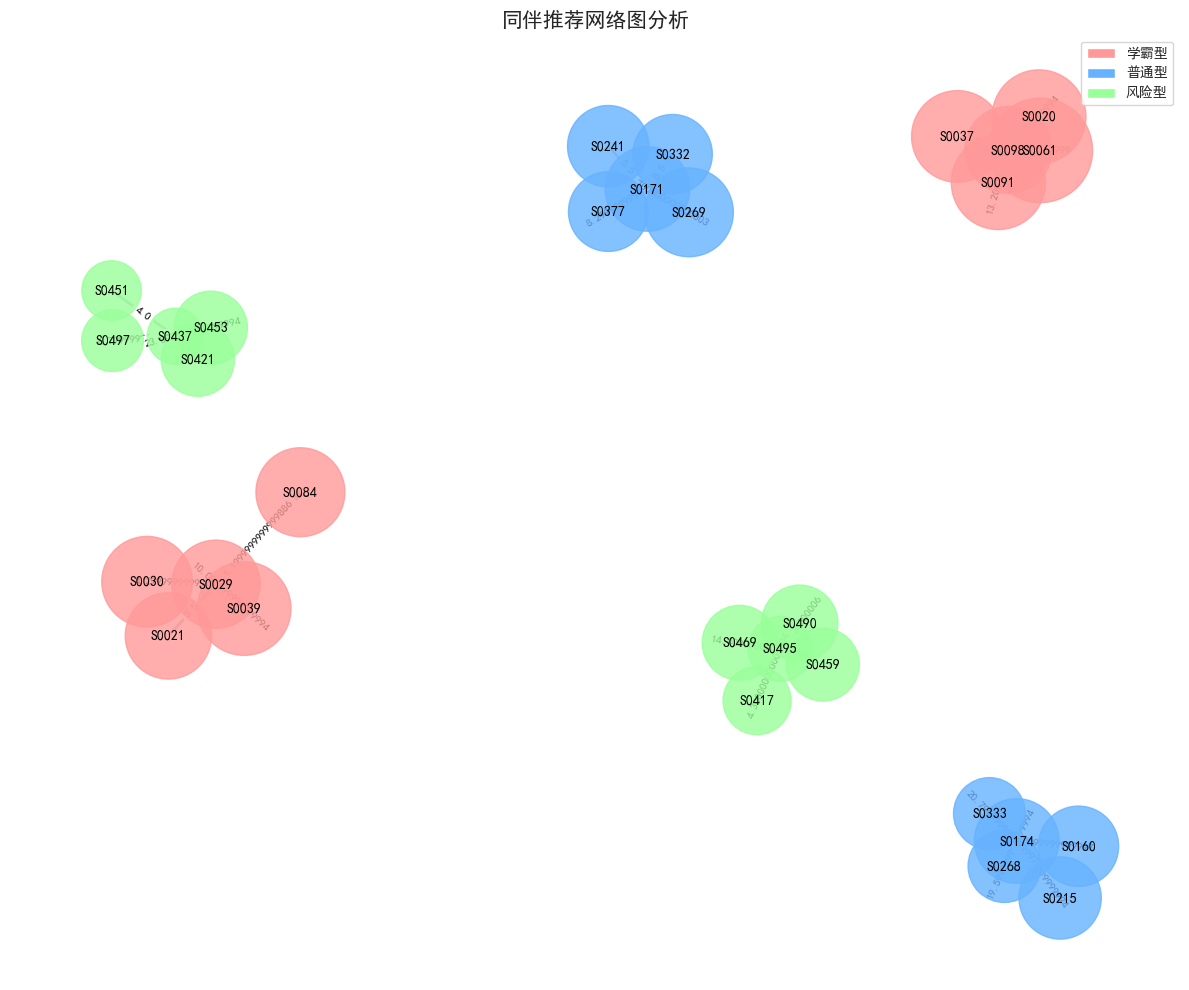


📊 网络特性分析:
节点数: 30
边数: 24
平均每个学生的推荐连接数: 1.60
网络聚类系数: 0.00

选中的学生及其推荐资源:
学生ID: S0029
类型: 学霸型, 成绩: 80.9
推荐资源: 学习小组
推荐同伴: ['S0021', 'S0030', 'S0084', 'S0039']
--------------------------------------------------
学生ID: S0098
类型: 学霸型, 成绩: 78.7
推荐资源: 学习小组
推荐同伴: ['S0091', 'S0037', 'S0061', 'S0020']
--------------------------------------------------
学生ID: S0171
类型: 普通型, 成绩: 74.1
推荐资源: 学习小组
推荐同伴: ['S0377', 'S0269', 'S0332', 'S0241']
--------------------------------------------------
学生ID: S0174
类型: 普通型, 成绩: 74.3
推荐资源: 学习小组
推荐同伴: ['S0268', 'S0160', 'S0215', 'S0333']
--------------------------------------------------
学生ID: S0437
类型: 风险型, 成绩: 32.7
推荐资源: 视频课程
推荐同伴: ['S0497', 'S0451', 'S0421', 'S0453']
--------------------------------------------------
学生ID: S0495
类型: 风险型, 成绩: 43.8
推荐资源: 视频课程
推荐同伴: ['S0459', 'S0469', 'S0490', 'S0417']
--------------------------------------------------


In [22]:


# ======================
# 10. 网络图分析同伴推荐系统
# ======================
import networkx as nx
import random

def get_color_for_type(student_type):
    colors = {
        '学霸型': '#FF9999', '普通型': '#66B2FF', '风险型': '#99FF99', '其他': '#FFCC99'
    }
    return colors.get(student_type, colors['其他'])

def create_peer_recommendation_graph(df, student_types=['学霸型', '普通型', '风险型'], samples_per_type=1):
    """
    创建同伴推荐网络图
    
    参数:
    df: 包含推荐结果的数据框
    student_types: 要包含的学生类型列表
    samples_per_type: 每种类型随机抽取的学生数量
    
    返回:
    G: 网络图对象
    selected_students: 被选中的学生信息
    """
    # 获取最新记录
    latest_records = get_latest_scores(df)
    
    # 为每种学生类型随机选择样本
    selected_students = []
    for st_type in student_types:
        type_students = latest_records[latest_records['student_type'] == st_type]
        if len(type_students) > 0:
            samples = type_students.sample(min(samples_per_type, len(type_students)))
            # 将样本转换为字典并添加颜色信息
            for _, sample in samples.iterrows():
                sample_dict = sample.to_dict()
                sample_dict['color'] = get_color_for_type(sample['student_type'])
                selected_students.append(sample_dict)
    
    # 创建网络图
    G = nx.Graph()
    
    # 添加选中的学生作为节点
    for student in selected_students:
        G.add_node(student['stu_id'], 
                   type=student['student_type'],
                   score=student['weekly_score'],
                   resource=student['recommended_resource'],
                   color=student['color'])
    
    # 添加边（推荐关系）
    for student in selected_students:
        stu_id = student['stu_id']
        # 获取该学生的推荐同伴
        recommended_peers = df[df['stu_id'] == stu_id]['recommended_peers'].iloc[0]
        
        # 添加推荐的同伴为节点（如果不存在）
        for peer_id in recommended_peers:
            # 检查同伴是否在最新记录中
            if peer_id in latest_records['stu_id'].values:
                peer_info = latest_records[latest_records['stu_id'] == peer_id].iloc[0].to_dict()
                # 确保节点存在
                if peer_id not in G:
                    # 确保包含所有必要的属性
                    peer_info['color'] = get_color_for_type(peer_info['student_type'])
                    G.add_node(peer_id, 
                               type=peer_info['student_type'],
                               score=peer_info['weekly_score'],
                               resource=peer_info['recommended_resource'],
                               color=peer_info['color'])
                
                # 计算成绩差异作为边的权重
                score_diff = abs(student['weekly_score'] - peer_info['weekly_score'])
                
                # 添加边
                G.add_edge(stu_id, peer_id, weight=score_diff)
    
    return G, selected_students

def plot_peer_recommendation_graph(G, selected_students, figsize=(12, 10), save_path='./data/visualization/KNN_Net_Recommend.png'):
    """
    绘制同伴推荐网络图
    
    参数:
    G: 网络图对象
    selected_students: 被选中的学生信息
    figsize: 图表大小
    save_path: 图片保存路径，若为None则不保存
    """
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    node_sizes = [G.nodes[node]['score'] * 50 for node in G.nodes()]
    edge_widths = [10 / (d['weight'] + 1) for _, _, d in G.edges(data=True)]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, {node: node for node in G.nodes()}, font_size=10, font_family='SimHei')
    nx.draw_networkx_edge_labels(G, pos, {(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_size=8)
    
    from matplotlib.patches import Patch
    # 直接使用get_color_for_type函数内部的颜色映射
    color_map = {
        '学霸型': '#FF9999',
        '普通型': '#66B2FF',
        '风险型': '#99FF99',
        '其他': '#FFCC99'
    }
    legend_elements = [Patch(facecolor=color, label=type_) 
                       for type_, color in color_map.items() if type_ != '其他']
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title('同伴推荐网络图分析', fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"网络图已保存至: {save_path}")
    
    plt.show()

def show_network_recommendations(df, student_types=['学霸型', '普通型', '风险型'], samples_per_type=1):
    print("🌐 同伴推荐网络图分析")
    print("="*50)
    G, selected_students = create_peer_recommendation_graph(df, student_types, samples_per_type)
    plot_peer_recommendation_graph(G, selected_students, save_path='./data/visualization/KNN_Net_Recommend.png')  # 保存路径示例
    
    print("\n📊 网络特性分析:")
    print(f"节点数: {G.number_of_nodes()}")
    print(f"边数: {G.number_of_edges()}")
    degrees = dict(G.degree())
    avg_degree = sum(degrees.values()) / len(degrees) if degrees else 0
    print(f"平均每个学生的推荐连接数: {avg_degree:.2f}")
    clustering = nx.average_clustering(G) if G.number_of_nodes() >= 3 else 0
    print(f"网络聚类系数: {clustering:.2f}")
    
    # 打印选中学生及其推荐资源
    print("\n选中的学生及其推荐资源:")
    print("="*50)
    for student in selected_students:
        print(f"学生ID: {student['stu_id']}")
        print(f"类型: {student['student_type']}, 成绩: {student['weekly_score']:.1f}")
        print(f"推荐资源: {student['recommended_resource']}")
        print(f"推荐同伴: {student['recommended_peers']}")
        print("-"*50)

# ======================
# 执行流程
# ======================
# 1. 应用SVD推荐
df = apply_svd_recommendation(df)
# 2. 应用KNN推荐
df = improved_knn_recommendation(df)
# 3. 展示网络图推荐（包含打印分析结果）
show_network_recommendations(df, samples_per_type=2)  # 建议抽取2个以上样本以增加连接概率